In [26]:
import glob
import rasterio as rio
from rasterio import mask, features
import numpy as np
import shapely.wkt as wkt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#big area
#sub_area = wkt.loads("MULTIPOLYGON (((77462.8497438607 73703.6291953883,75345.6534984474 73935.3621177719,75366.720127755 74009.0953203485,74843.5654999498 74153.050620617,74836.5432901806 74184.6505645784,74889.2098634495 74542.7832628075,74854.0988146036 74985.182478267,74861.1210243728 75301.1819178809,74882.1876536804 75536.4259451491,74959.4319611415 75813.8032310324,76511.3403201343 75448.6483230341,76967.7839551322 75329.2707569577,76985.3394795552 74995.7157929208,77564.671785514 74005.5842154639,77462.8497438607 73703.6291953883)))")

#small area
sub_area = wkt.loads("POLYGON ((76149.3828127647 73922.4335140161,76110.5488176897 74065.2871387564,75745.7866496635 74733.7866254053,75974.6298349271 74830.8716130929,76478.084842507 75002.8507341395,76532.175049933 74790.6506896223,76514.144980791 74653.3447784641,76514.144980791 74529.9081512613,76584.8783289634 74276.100254878,76451.7332029918 73934.9158695759,76149.3828127647 73922.4335140161))")

folders = glob.glob('/mnt/ric_dais_nfs_maccari/gabriel/results/ComComVSI/*')

for f in folders:
    t = f.split(sep='/')[-1][8:]
    dataset = rio.open(f'/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_{t}_mask.tif', 'r', crs='EPSG:2169')
    raster, _ =  rio.mask.mask(dataset, [sub_area], crop=True, indexes=1)    
    print(t, raster.sum())
    targets[t] = raster

# sumo_mask = rio.open('/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_cars_sumo_mask.tif', 'r', crs='EPSG:2169')
# sumo, transf_car =  rio.mask.mask(sumo_mask, [sub_area], crop=True, indexes=1)

# roads_mask = rio.open('/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_roads_mask.tif', 'r', crs='EPSG:2169')
# roads, transf_car =  rio.mask.mask(roads_mask, [sub_area], crop=True, indexes=1)

# sidewalks_mask = rio.open('/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_sidewalk_mask.tif', 'r', crs='EPSG:2169')
# sidewalks, transf_car =  rio.mask.mask(sidewalks_mask, [sub_area], crop=True, indexes=1)


# sidewalksparks_mask = rio.open('/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_sidewalkparks_mask.tif', 'r', crs='EPSG:2169')
# sidewalksparks, transf_car =  rio.mask.mask(sidewalks_mask, [sub_area], crop=True, indexes=1)

# pedestian_dataset = rio.open('/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_roads_mask.tif', 'r', crs='EPSG:2169')
# pedestrians, transf_ped =  rio.mask.mask(pedestian_dataset, [sub_area], crop=True, indexes=1)

result_files = glob.glob('/mnt/ric_dais_nfs_maccari/gabriel/results/ComComVSI/*/luxemburg/threestep/2/r1/1/*/*/viewshed.tif')


sidewalkparks 130433
roads 98035
sidewalk 58328
cars_sumo 273034
oldroads 138644


In [35]:
results = []
for f in result_files:
    run_t, city, strategy, subarea, ranking, k, ratio, dens = f.split('/')[6:-1]
    algorithm = run_t.split('_')[1]
    with rio.open(f, 'r', crs='EPSG:2169') as dataset:
        res, transf =  rio.mask.mask(dataset, [sub_area], crop=True, indexes=1)
    # if algorithm == 'cars':
    #     res = np.where(res>0, sumo, 0)
    # else:
    #     #keep only the booleanized results
    #     res = np.where(res>0, 1, 0)

    # sumo_res = np.where(res>0, sumo, 0)
    # roads_res = np.multiply(np.where(res>0, 1, 0), roads)
    # sidewalks_res = np.multiply(np.where(res>0, 1, 0), sidewalks)
    # sidewalksp_res = np.multiply(np.where(res>0, 1, 0), sidewalksparks)
    #cars_res = np.where(res>0, sumo, 0)
    # ##cars metric
    for t in targets_base.keys():
        base = np.where(targets_base[t]>0, 1, 0)
        tres = np.where(res>0, base, 0)#, base[t])
        results.append({'metric': t,
                        'algorithm': algorithm, 
                        'dens': int(dens), 
                        'ratio': float(ratio),
                        'sum': tres.sum(),
                        'total': base.sum(),
                        'coverage': tres.sum()/base.sum(),
                        })
    #weighted sumo
    base = targets_base['cars_sumo']
    tres = np.where(res>0, base, 0)#, base[t])
    results.append({'metric': 'weighted sumo',
                    'algorithm': algorithm, 
                    'dens': int(dens), 
                    'ratio': float(ratio),
                    'sum': tres.sum(),
                    'total': base.sum(),
                    'coverage': tres.sum()/base.sum(),
                    })
            
    # results.append({'metric': 'sumo',
    #                 'algorithm': algorithm, 
    #                 'dens': int(dens), 
    #                 'ratio': float(ratio),
    #                 'sum': sumo_res.sum(),
    #                 'total': sumo.sum(),
    #                 'coverage': sumo_res.sum()/sumo.sum(),
    #                 })
    
    # # sidewalks metric
    # results.append({'metric': 'sidewalks',
    #                 'algorithm': algorithm, 
    #                 'dens': int(dens), 
    #                 'ratio': float(ratio),
    #                 'sum': sidewalks_res.sum(),
    #                 'total': sidewalks.sum(),
    #                 'coverage': sidewalks_res.sum()/sidewalks.sum(),
    #                 })
    # # sidewalks parks metric
    # results.append({'metric': 'sidewalkspark',
    #                 'algorithm': algorithm, 
    #                 'dens': int(dens), 
    #                 'ratio': float(ratio),
    #                 'sum': sidewalksp_res.sum(),
    #                 'total': sidewalksparks.sum(),
    #                 'coverage': sidewalksp_res.sum()/sidewalksparks.sum(),
    #                 })
    # #roads metric
    # results.append({'metric': 'roads',
    #                 'algorithm': algorithm, 
    #                 'dens': int(dens), 
    #                 'ratio': float(ratio),
    #                 'sum': roads_res.sum(),
    #                 'total': roads.sum(),
    #                 'coverage': roads_res.sum()/roads.sum(),
    #                 })
    
    # boolcar_res = np.where(sumo_res>0, 1, 0)
    # # #boolcar version
    # results.append({'metric': 'boolean sumo',
    #                 'algorithm': algorithm,
    #                 'dens': int(dens), 
    #                 'ratio': float(ratio),
    #                 'sum': boolcar_res.sum(),
    #                 'total': np.count_nonzero(sumo),
    #                 'coverage': boolcar_res.sum()/np.count_nonzero(sumo)
    #                 })
    # # #pedestrian version
    # pedestrian_res = np.where(res>0,1,0)
    # results.append({'metric': 'pedestrian',
    #                 'algorithm': algorithm,
    #                 'dens': int(dens), 
    #                 'ratio': float(ratio),
    #                 'sum': np.count_nonzero(pedestrian_res),
    #                 'total': np.count_nonzero(local_pedestrians),
    #                 'coverage': np.count_nonzero(pedestrian_res)/np.count_nonzero(local_pedestrians)
    #                 })
    
res_df = pd.DataFrame(results)

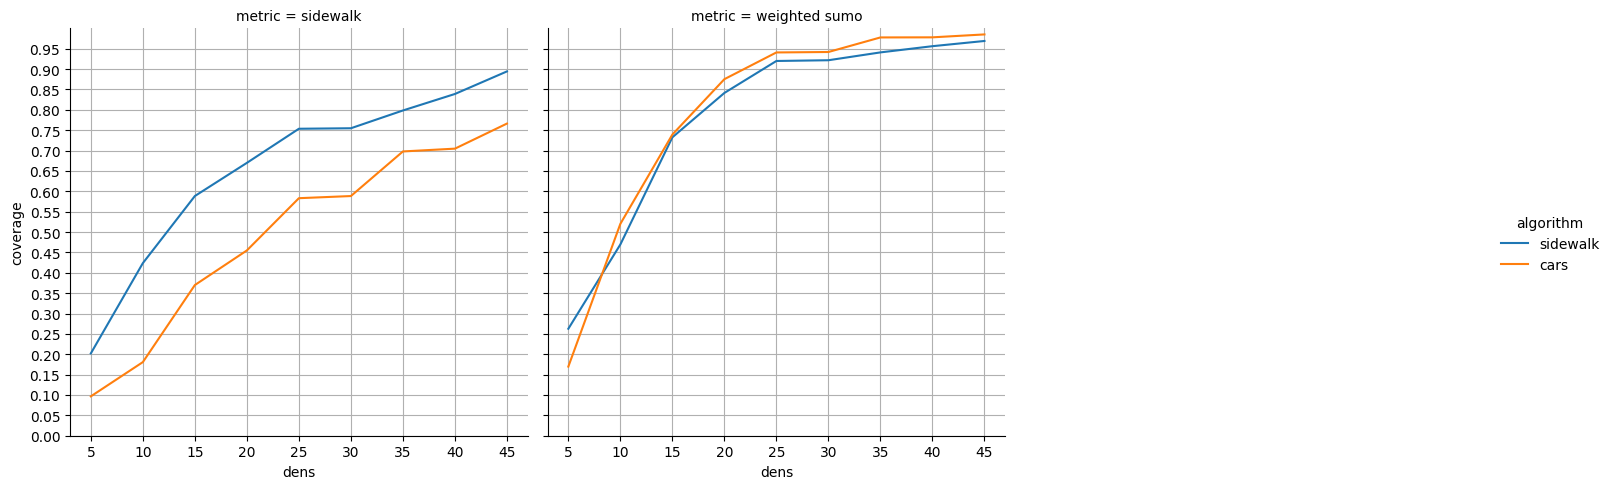

In [50]:
filt_data = res_df[(res_df.dens <= 90) & (res_df.ratio ==100.0) & res_df.metric.isin(['sidewalk', 'weighted sumo']) & res_df.algorithm.isin(['sidewalk', 'cars'])]
#print(filt_data.pivot('dens', ['algorithm', 'metric'], 'coverage'))
sns.relplot(data=filt_data, x='dens', y='coverage', kind='line', hue='algorithm', col='metric', col_wrap=3)
#print(filt_data[filt_data.metric=='pedestrian'])
plt.ylim([0,1])
plt.yticks([i/20 for i in range(0,20)])
for ax in plt.gcf().get_axes():
    ax.grid()
